Sei $C, \dim(C)=(n,n,2)$ das Array der Segment-Koordinaten.  

Sei $f_1(x)$ die Distanzfunktion des Strahls durch $g_1$ bis $x$. $\quad (d_{\mathrm{cell},g_1}, d_{\mathrm{cell},g_1})^T = f_1(x)$.

Sei $p(x)$ die Indexprojektion der Koordinaten auf $C$. $\quad p(x) = (i,j)^T$ mit $C_{i,j} = x$.

Sei $\mathrm{rot}(x,\alpha)$ die CW-Rotation von $x$ um $\alpha$ Grad um den Ursprung.

Schritt 1:   
* __Input__: $C, D, \quad \forall i,j: D_{i,j}=(0,0)^T$.  
* __Algorithmus__:  
    $\forall c \in C: D_{p(c)} = f_1(c)$
* __Output__: $D$

Schritt 2: 
* __Input__: $C, D, E$  
* __Berechnung__:  
 $\forall i,j \in p(C): E_{i,j} = D_{i,j} + D_{p(\mathrm{rot}(C_{i,j}, \alpha))}$
(Im Shader über $C$ laufen, Punkt rotieren ($\mathrm{rot}(c, \alpha)$), in Indizes des neuen Punktes umwandeln.   
 $g_2$ Distanzen in $D$ an Stelle $c \in C$ über $g_1$ Distanzen an Stelle $\mathrm{rot, \alpha}(c) \in C$ setzen.  
* __Output__: $E$

In [7]:
import numpy as np
norm = np.linalg.norm
sqrt = np.math.sqrt
dot = np.dot
array = np.array
from scipy.spatial.transform import Rotation
import scipy.ndimage
import pandas as pd
import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
class Tools:
    def coord_search(target, coords, eps=1e-2):
        if not isinstance(target, np.ndarray):
            target = array(target)
        mask = np.apply_along_axis(all, 2, (coords >= target-eps) & (coords <= target+eps))
        return np.argwhere(mask)

In [4]:
class Segmentation:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
        if "theta" in kwargs:
            self.set_angle(kwargs["theta"])
        else:
            raise ValueError("Diffraction angle missing.")
            
    def set_angle(self, angle, degrees=True):
        if np.isclose(angle, 45.0):
            self.m = np.infty
            self.n = array([1,0])
        else:
            self.m = np.tan(angle*np.pi/90)
            self.n = array([1, -1.0/self.m])/norm(array([1, -1.0/self.m]))
        self.rot_mat = Rotation.from_euler("z", 180-2*angle, degrees=degrees).as_matrix()[:2,:2]

    def coord(self, step, a, b, dim):
        return a + step*(b-a)/(dim-1)

    def coord2idx(self, x, a, b, dim, decimals=0):
        """Turn coordinates into indices"""
        return np.around(((x-a) * (dim-1)/(b-a)), decimals=decimals).astype(int)   
    
    def rot(self, x, origin, angle=None, degrees=True):
        if angle is not None:
            rot_mat = Rotation.from_euler("z", 180-2*angle, degrees=degrees).as_matrix()[:2,:2]
        return origin + (x-origin) @ self.rot_mat
    
    def rotate(self, array, angle=None):
        if angle is None:
            angle = self.theta
        #scipy.ndimage.rotate(array, -180+2*angle, reshape=False)
        return np.matmul(array, seg.rot_mat)
    
    def gen_coords(self, a, b, dim, dtype=np.float64):
        return array([[[self.coord(i, a, b, dim), self.coord(j, a, b, dim)] for i in range(dim)] for j in range(dim)], dtype=dtype)

    def intersectDR(self, x, radius, right=True):
        ray_0 = dot([-self.m, 1], x)
        c = dot(self.n, x)
        return dot(self.n, array([c, ((-1)**right)*sqrt(radius**2 - c**2)]))*array([1, self.m]) + array([0, ray_0])

    def intersectER(self, x, radius, right=True):
        return array([(-1)**int(not right)*sqrt(radius**2 - x[1]**2), x[1]])

    def dist(self, x, total=False, case=1):
        """
        Computes travel distance of ray through medium with diffraction point in x
        """
        if case==1:
            # case A_{s,sc}
            return self.dist_F1(x, total=total)
        elif case==2:
            # case A_{c,sc}
            if np.isinf(self.m):
                return self.dist_F2_90(x, total=total)
            return self.dist_F2(x, total=total)
        elif case==3:
            # case A_{c,c}
            return self.dist_F3(x, total=total)
        else:
            return None
        
    def dist90(self, x, total=False, case=1):
        """
        Computes travel distance of ray through medium with diffraction point in x
        """
        if case==1:
            # case A_{s,sc}
            return self.dist_F1_90(x, total=total)
        elif case==2:
            # case A_{c,sc}
            return self.dist_F2_90(x, total=total)
        elif case==3:
            # case A_{c,c}
            return self.dist_F3_90(x, total=total)
        else:
            return None
    
    def dist_F1(self, x, total=False):
        """
        REN = ray entry point
        REX = ray exit point
        
        (case A_{s,sc})
        """

        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if norm(x) <= self.r_sample:
            REN_outer = self.intersectER(x, self.r_cell, right=0)
            REN_inner = self.intersectER(x, self.r_sample, right=0)
            
            d_sample = norm(x - REN_inner)
            d_cell = norm(REN_inner - REN_outer)
                
        if total:
            return d_cell, d_sample, d_cell+d_sample
        return d_cell, d_sample

    def dist_F1_90(self, x, total=False):
        """(case A_{s,sc})"""

        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if norm(x) <= self.r_sample:
            REN_g1o = self.intersectER(x, self.r_cell, right=0)
            REN_g1i = self.intersectER(x, self.r_sample, right=0)
            
            d_sample = norm(x - REN_g1i)
            d_cell = norm(REN_g1i - REN_g1o)
                
        if total:
            return d_cell, d_sample, d_cell+d_sample
        return d_cell, d_sample
    
    def dist_F2(self, x, total=False): 
        """(case A_{c,sc})"""
        
        # 1
        d_cell, d_sample = 0.0, 0.0
        # 2
        if self.r_sample < norm(x) <= self.r_cell:
            REN_g1o = self.intersectER(x, self.r_cell, right=0)
            
            if (x[0] >= 0 and abs(x[1]) < self.r_sample): # right of sample and ER intersection
                REN_g1i = self.intersectER(x, self.r_sample, right=0)
                REX_g1i = self.intersectER(x, self.r_sample)
                d_cell = norm(REN_g1o - REN_g1i) + norm(REX_g1i - x)
                d_sample = norm(REN_g1i - REX_g1i)

            else: # left of sample or no ER sample intersection
                d_cell = norm(REN_g1o - x)
                d_sample = 0.0
            
        if total:
            return d_cell, d_sample, d_cell+d_sample
        return d_cell, d_sample

    def dist_F2_90(self, x, total=False):
        """(case A_{c,sc}) when theta=45°."""
        return self.dist_F2(x, total=total)
    
    def dist_F3(self, x, total=False): 
        """(case A_{c,c})"""
        d_cell, d_sample = self.dist_F2(x)
        if total:
            return d_cell, 0, d_cell
        else:
            return d_cell, 0

    def dist_F3_90(self, x, total=False): 
        """(case A_{c,c})"""
        d_cell, d_sample = self.dist_F2_90(x)
        if total:
            return d_cell, 0, d_cell
        else:
            return d_cell, 0
            
    def get_g1_dists(self, resolution, margin=1.2, total=False, case=1, coords=None):
        if coords is None:
            coords = self.gen_coords(-self.r_cell*margin, self.r_cell*margin, dim=resolution)
        if np.isinf(self.m):
            return np.apply_along_axis(self.dist90, 2, coords, total=total, case=case)
        return np.apply_along_axis(self.dist, 2, coords, total=total, case=case)
    
    def g2_from_g1(self, idx, source):
        if np.any(idx >= source.shape[:2]) or np.any(idx < 0):
            return np.zeros(source.shape[-1])
        return source[tuple(idx)]
    
    def get_g2_dists(self, resolution, margin=1.2, total=False, case=1, coords=None, g1_dists=None):
        if coords is None:
            coords = self.gen_coords(-self.r_cell*margin, self.r_cell*margin, dim=resolution)
        if g1_dists is None:
            g1_dists = self.get_g1_dists(resolution, margin, total, case, coords)
        if coords.shape[0] != g1_dists.shape[0]:
            raise ValueError("Coordinate shape does not match distances shape.")
        coords_rotated = self.rotate(coords)
        #np.apply_along_axis(self.rot, 2, coords, origin=array([0,0]))
        #indices_rotated = np.apply_along_axis(self.coord2idx, 2, coords_rotated, 
        #    -self.r_cell*margin, self.r_cell*margin, dim=resolution)

        #g2_dists = np.apply_along_axis(self.g2_from_g1, 2, indices_rotated, source=g1_dists)
        g2_dists = self.get_g1_dists(resolution, margin, total, case, coords=coords_rotated)
        
        return g2_dists
    
    def get_dists(self, resolution, margin=1.2, total=False, case=1, coords=None, g1_dists=None):
        if g1_dists is None:
            g1_dists = self.get_g1_dists(resolution, 
                margin=margin, total=total, case=case, coords=coords)
        g2_dists = self.get_g2_dists(resolution, 
            margin=margin, total=total, 
            case=case, coords=coords, g1_dists=g1_dists)
        return g1_dists+g2_dists
    
    def scale_to(self, outer):
        """Scale distances by difference in radii."""
        pass

    def step_angle(self, angles, resolution=80, margin=1.2, cases=[1,2,3], coords=None, pbar=None):
        factors = np.zeros(shape=(len(angles), len(cases)))
        g1_dists = array([self.get_g1_dists(resolution, margin=margin, case=case, coords=coords) 
                    for case in cases])
        
        for i in range(len(angles)):
            for case in cases:
                self.set_angle(angles[i])
                distances = self.get_dists(
                    resolution, margin=margin, case=case, coords=coords, g1_dists=g1_dists[case-1])
                factors[i,case-1] = self.get_absorptionfactor(distances, self.mu, case=case)
            pbar.update(1)
        return factors    
    
    def plot_dists(self, resolution, margin=1.2, total=False, cmap=None, distances=None):
        if distances is None:
            distances = self.get_dists(resolution, margin=margin, total=total)
        
        titles = ["Cell", "Sample", "Total"]
        fig, axes = plt.subplots(ncols=distances.shape[2], figsize=(16,10), gridspec_kw={'width_ratios': [1]*distances.shape[2]})
        for i in range(distances.shape[2]):
            im = axes[i].imshow(distances[:,:,i], 
                        cmap=cmap, interpolation='none', 
                        origin="lower",
                        extent=[-self.r_cell*margin,self.r_cell*margin]*2,
                        vmin=distances.min(), vmax=distances.max()
                    )
            axes[i].set_title(titles[i] + " distances")
        
        if cmap is None:
            cmp = plt.cm.get_cmap("viridis", 10)
        cmp.set_bad(color='red')
        cmp.set_under(color="black")
        fig.colorbar(im, ax=axes, orientation='horizontal', fraction=.1, aspect=30, pad=0.1)
        return axes
    
    def plot_absorbfactors(self, angles=np.linspace(1.0,90,5), resolution=80, margin=1.2, figsize=(18,4), pbar=None):
        angle_absorptions = self.get_absorptionfactors(angles, resolution=resolution, margin=margin, pbar=pbar)

        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True)
        st = fig.suptitle(f"Absorptions for angles [{angles.min()},...,{angles.max()}]", fontsize=14)
        st.set_y(1.04)

        case_strings = ["A_{s,sc}", "A_{c,sc}", "A_{c,c}"]
        colors = ["violet", "orange", "red"]
        for i in range(3):
            axs[i].plot(angles, angle_absorptions[:,i], color=colors[i])
            axs[i].set_title(f"{case_strings[i]}")

        return fig,axs 
    
    def get_absorptionfactors(self, angles=np.linspace(1.0,90,5), resolution=80, margin=1.2, pbar=None):
        if pbar is None:
            pbar = tqdm(total=angles.size)
        coords = self.gen_coords(-self.r_cell*margin, self.r_cell*margin, dim=resolution)
        angle_absorptions = self.step_angle(angles, resolution=resolution, coords=coords, margin=margin, pbar=pbar)
        return angle_absorptions

    def get_absorptions(self, mu, distances):
        return np.apply_along_axis(lambda x: np.exp(-np.dot(mu, x)), 2, distances)
    
    def save_absorptionfactors(self, path, factors, angles, float_format="%.3f"):
        df = pd.DataFrame(absorptions, index=angles, columns=["A_{s,sc}", "A_{c,sc}", "A_{c,c}"])
        df.index.name = "2 theta"
        df.index = df.index.map(lambda x: float_format % x)
        df.to_csv(path)
    
    def get_absorptionfactor(self, distances, mu, case=None):
        if case is None:
            case_mask = [1,1]
        else:
            case_mask = [[1,1], [1,1], [1,0]][case-1]
        absorptions = self.get_absorptions(case_mask*mu, distances)
        return np.sum(absorptions[absorptions!=1])/absorptions[absorptions!=1].shape[0]

In [5]:
params = {
    "theta" : 45.0,
    "r_cell" : 1.5,
    "r_sample" : 1.0,
    "mu" : array([.54747*1E-1, 6.70333*1E-1]),   # cell, sample.
}

In [6]:
ndim = 256
margin = 1.05
seg = Segmentation(**params)

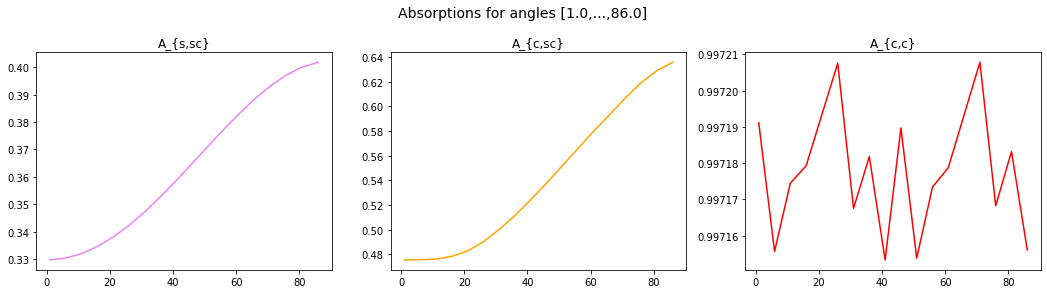

In [83]:
angles = np.arange(1.0,90,5.0)
fig, axs = seg.plot_absorbfactors(angles, resolution=320);

In [84]:
def absorb_asymptote(resolutions, segment, case=1, margin=1.1):
    segm = segment
    absorb_factors = np.zeros(len(resolutions))
    for i in range(len(resolutions)):
        distances = segm.get_dists(resolution=resolutions[i], margin=margin, case=case)
        absorb_factors[i] = segm.get_absorptionfactor(distances, segm.mu, case=case)
    return absorb_factors

In [85]:
seg.set_angle(50.0)

In [86]:
steps = 2**np.arange(4,11)+1
absorb_precision_case1 = absorb_asymptote(steps, seg)
absorb_precision_case2 = absorb_asymptote(steps, seg, case=2)
absorb_precision_case3 = absorb_asymptote(steps, seg, case=3)

absorb_precisions = (absorb_precision_case1, absorb_precision_case2, absorb_precision_case3)

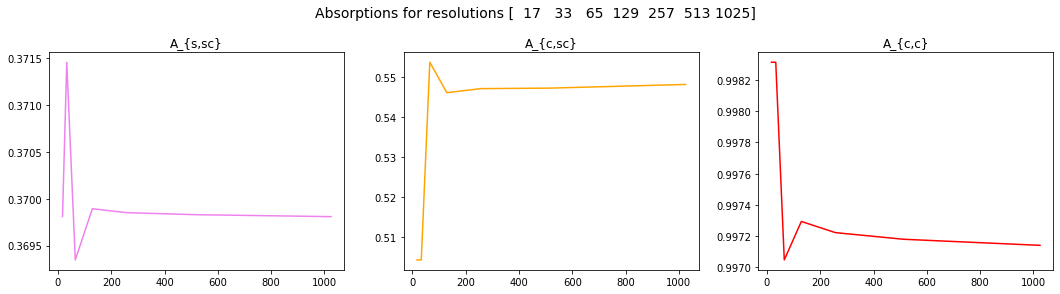

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(18,4), sharex=True)
st = fig.suptitle(f"Absorptions for resolutions {steps}", fontsize=14)
st.set_y(1.04)

case_strings = ["A_{s,sc}", "A_{c,sc}", "A_{c,c}"]
colors = ["violet", "orange", "red"]
for i in range(3):
    axs[i].plot(steps, absorb_precisions[i], color=colors[i])
    axs[i].set_title(f"{case_strings[i]}")

In [88]:
for AP in absorb_precisions:
    print(AP)

[0.36981024 0.37145771 0.36934683 0.36989335 0.36985179 0.36982998
 0.36980896]
[0.50419531 0.50419531 0.55369516 0.54607144 0.54708971 0.54721314
 0.54813185]
[0.99831323 0.99831323 0.99704758 0.99729377 0.99722223 0.99717979
 0.99714085]


<div style="height:5mm">

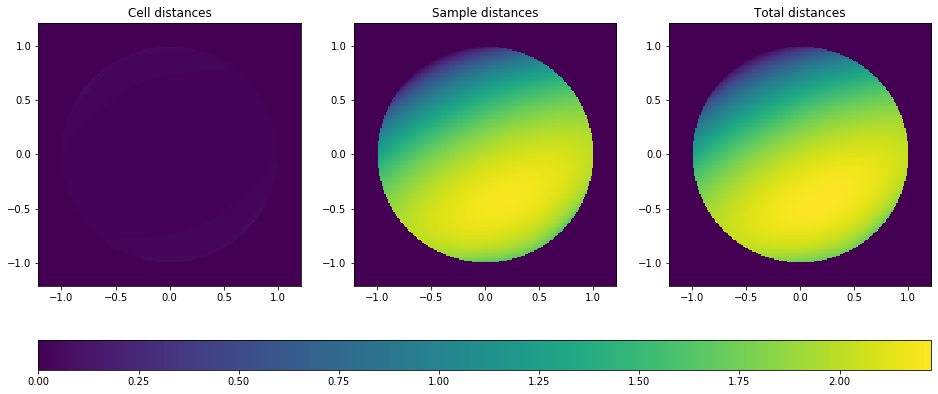

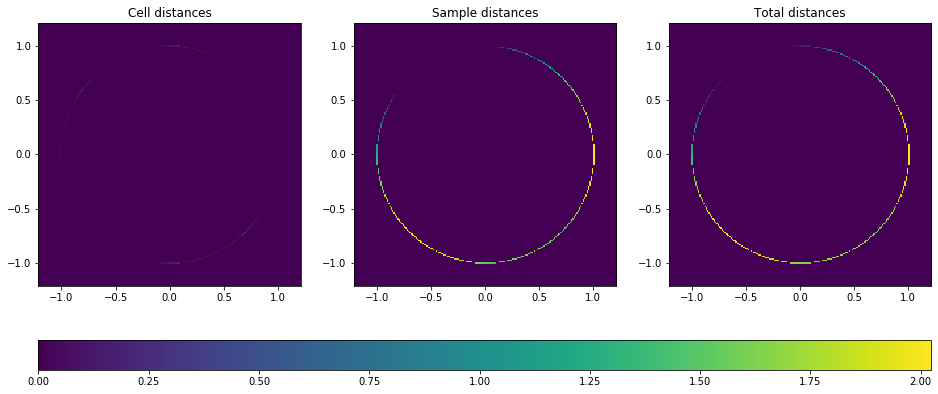

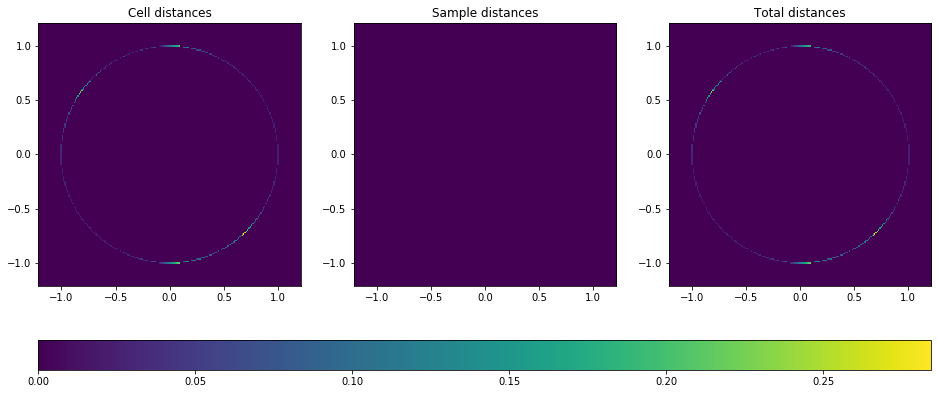

In [89]:
seg.set_angle(42.0)
for i in range(3):
    distances = seg.get_dists(resolution=ndim, total=1, case=i+1)
    seg.plot_dists(ndim, distances=np.flip(distances,0), total=True);

#### Generate data for comparison

In [233]:
ndim = 256
angles = np.arange(2.5, 50.0, 0.05)

In [234]:
with tqdm(total=angles.size) as pbar:
    absorptions = seg.get_absorptionfactors(angles, resolution=ndim, pbar=pbar)

In [235]:
seg.save_absorptionfactors(f"data/factors_1D (res={ndim}).txt", absorptions, 2*angles, float_format='%.1f')

In [267]:
py_256 = pd.read_csv(f"data/factors_1D (res={256}).txt", index_col=0)
py_512 = pd.read_csv(f"data/factors_1D (res={512}).txt", index_col=0)

In [269]:
cs_256 = pd.read_csv(f"UnityStuff/Logs/Absorptions2D/Output n={256}.txt", sep="\t", index_col=0)
cs_256.index.name = "2 theta"
cs_512 = pd.read_csv(f"UnityStuff/Logs/Absorptions2D/Output n={512}.txt", sep="\t", index_col=0)
cs_512.index.name = "2 theta"

In [283]:
df_ref = pd.read_csv(f"data/factors_1D ref.txt", sep="\t", index_col=0)
df_ref.columns = ["A_{s,sc}", "A_{c,c}", "A_{c,sc}"]
df_ref = df_ref[cs_256.columns]

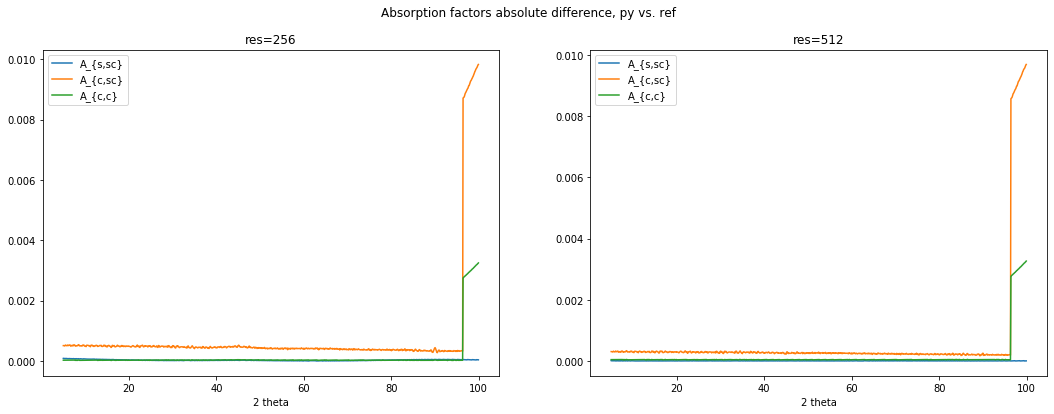

In [286]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
plt.suptitle("Absorption factors absolute difference, py vs. ref")
(df_ref-py_256).abs().plot(ax=ax[0], title="res=256");
(df_ref-py_512).abs().plot(ax=ax[1], title="res=512");
plt.savefig("Absorption factors absolute difference, py vs. ref.png", dpi=600)

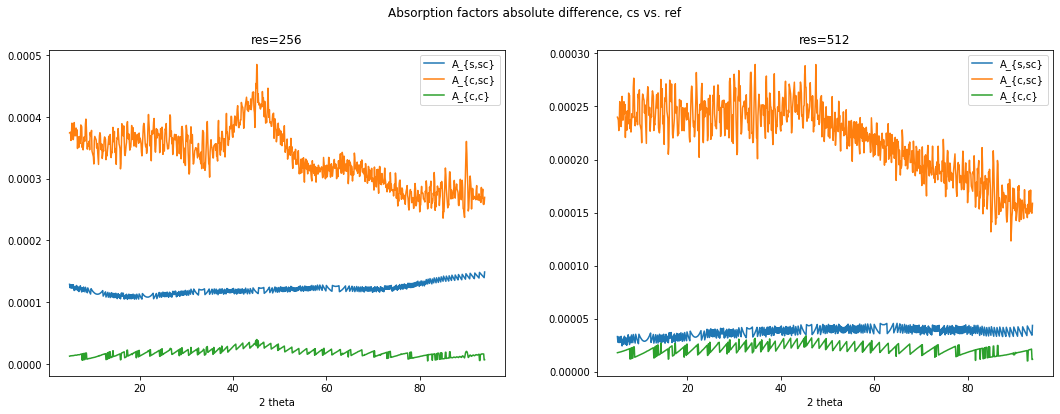

In [289]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
plt.suptitle("Absorption factors absolute difference, cs vs. ref")
(df_ref-cs_256)[df_ref.index<94].abs().plot(ax=ax[0], title="res=256");
(df_ref-cs_512)[df_ref.index<94].abs().plot(ax=ax[1], title="res=512");
plt.savefig("Absorption factors absolute difference, cs vs. ref.png", dpi=600)

In [270]:
pycs_256 = py_256.apply(lambda col: col - cs_256[col.name], axis=0)
pycs_512 = py_512.apply(lambda col: col - cs_512[col.name], axis=0)

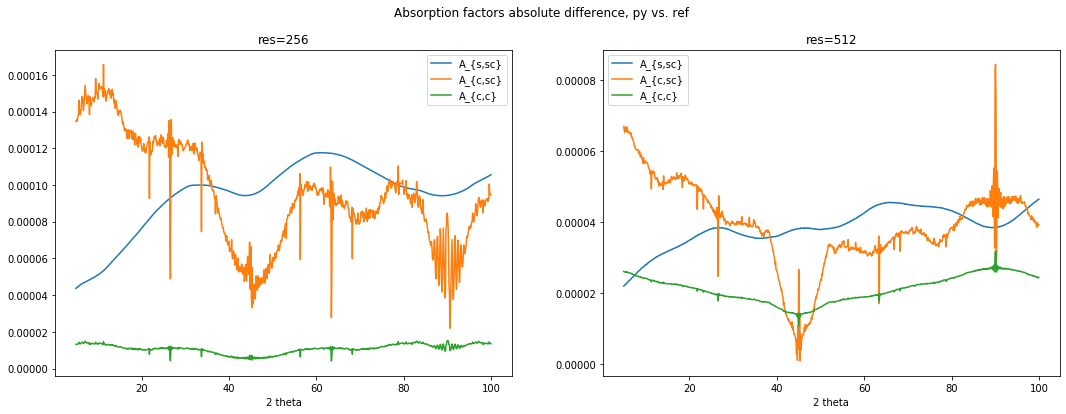

In [273]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
plt.suptitle("Absorption factors absolute difference, py vs. cs")
pycs_256.abs().plot(ax=ax[0], title="res=256");
pycs_512.abs().plot(ax=ax[1], title="res=512");
plt.savefig("Absorption factors absolute difference, py vs. cs.png", dpi=600)

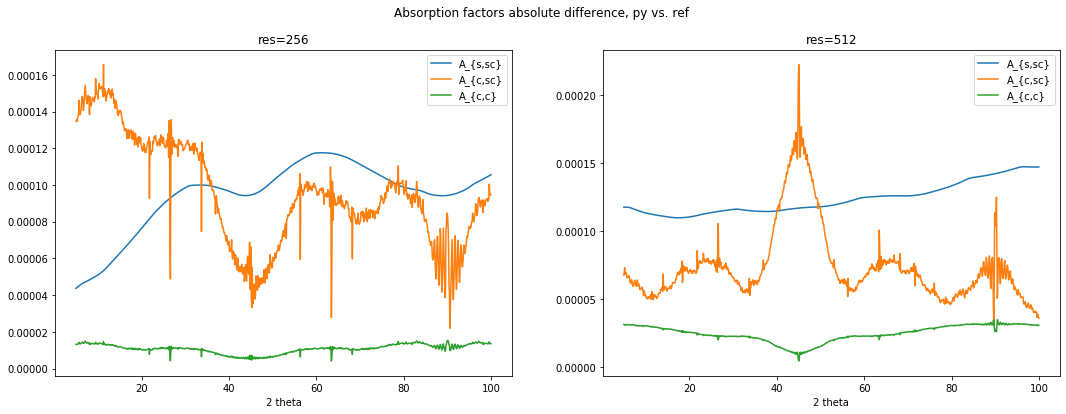

In [255]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
plt.suptitle("Absorption factors absolute difference, py vs. ref")
diff_256.abs().plot(ax=ax[0], title="res=256");
diff_512.abs().plot(ax=ax[1], title="res=512");
plt.savefig("Absorption factors absolute difference, py vs. ref.png", dpi=600)

In [259]:
diff_256.abs().mean() - diff_512.abs().mean()

A_{s,sc}   -0.000029
A_{c,sc}    0.000021
A_{c,c}    -0.000014
dtype: float64

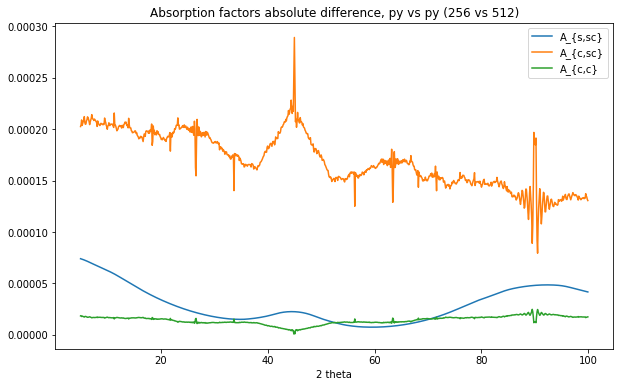

In [263]:
title="Absorption factors absolute difference, py vs py (256 vs 512)"
(df_256-df_512).abs().plot(figsize=(10,6), title=title)
plt.savefig(title, dpi=600)

In [141]:
seg.set_angle(30.0)
testdim = 1024
d_py_inner = seg.get_dists(testdim, margin=1.05, total=1, case=1)
d_py_outer = seg.get_dists(testdim, margin=1.05, total=1, case=2)

In [82]:
def load(filename, foldername):
    json_path = os.path.join("UnityStuff", "Logs", foldername, filename)
    with open(json_path, "r") as f:
        return json.load(f)

In [143]:
d_cs_inner = load(f"Dists inner n={testdim}.txt", "Distances2D")
d_cs_outer = load(f"Dists outer n={testdim}.txt", "Distances2D")

d_cs_inner = {k : array(v) for k,v in d_cs_inner.items()}
d_cs_outer = {k : array(v) for k,v in d_cs_outer.items()}

In [144]:
diffs_outer = (np.flip(d_cs_outer["60"],0)-d_py_outer[:,:,:2])
diffs_inner = (np.flip(d_cs_inner["60"],0)-d_py_inner[:,:,:2])

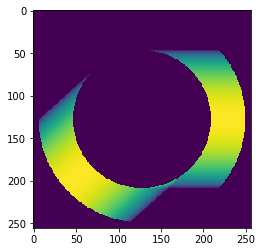

In [125]:
plt.imshow(d_py[:,:,1])

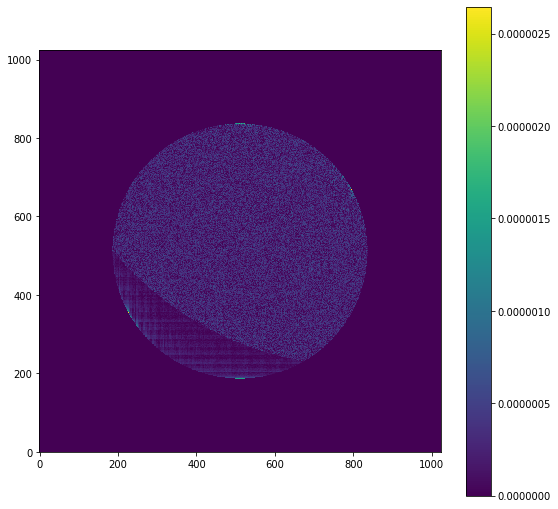

In [160]:
fig, ax = plt.subplots(figsize=(9,9))
im = plt.imshow(np.abs(diffs_inner)[:,:,1], origin="lower")
plt.colorbar(im)